# Module import

In [1]:
import pandas as pd 
import numpy as np 
import warnings 
import sys
import platform
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt 

from sklearn.model_selection import KFold
from tqdm import tnrange, tqdm_notebook

import optuna
from optuna.samplers import TPESampler

import lightgbm
from lightgbm import LGBMRegressor

import catboost
from catboost import CatBoostRegressor

In [2]:
# 운영체제 및 python 버전
print(platform.platform()) 
print(sys.version)

# 패키지 버전은 requirements.txt 파일에 명시
# !pip freeze > requirements.txt

Windows-10-10.0.19041-SP0
3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]


In [5]:
# 데이터셋 및 외부 데이터셋 불러오기

train_data = pd.read_csv('./dataset/train.csv')
train_cl = pd.read_csv('./dataset/train_cl.csv') 
train_hi = pd.read_csv('./dataset/train_hi.csv') 
train_pi = pd.read_csv('./dataset/train_pi.csv')
train_hr = pd.read_csv('./dataset/train_hr.csv')

test_data = pd.read_csv('./dataset/test.csv')
test_cl = pd.read_csv('./dataset/test_cl.csv')
test_hi = pd.read_csv('./dataset/test_hi.csv')
test_pi = pd.read_csv('./dataset/test_pi.csv')
test_hr = pd.read_csv('./dataset/test_hr.csv')

In [6]:
# 데이터셋과 외부 데이터셋을 병합 

trainset = pd.merge(train_data, train_cl, on='date')
trainset = pd.merge(trainset, train_hi, on='date')
trainset = pd.merge(trainset, train_pi, on='date')
trainset = pd.merge(trainset, train_hr, on='date', how='left')

testset = pd.merge(test_data, test_cl, on='date')
testset = pd.merge(testset, test_hi, on='date')
testset = pd.merge(testset, test_pi, on='date')
testset = pd.merge(testset, test_hr, on='date', how='left')

In [7]:
# 결측값 처리
trainset['precipitation'] = trainset["precipitation"].replace(np.nan, 0)
trainset['hr'] = trainset["hr"].replace(np.nan, 0)
trainset["PM10"] = trainset["PM10"].fillna(trainset["PM10"].median())
trainset["PM2.5"] = trainset["PM2.5"].fillna(trainset["PM2.5"].median())
trainset["sunshine_sum"] = trainset["sunshine_sum"].fillna(trainset["sunshine_sum"].median())
trainset["pi"] = trainset["pi"].fillna(trainset["pi"].median())

# 테스트 데이터셋의 PM10, PM2.5는 결측값 X
testset['precipitation'] = testset["precipitation"].replace(np.nan, 0)
testset['hr'] = testset["hr"].replace(np.nan, 0)
testset['sunshine_sum'] = testset['sunshine_sum'].fillna(testset['sunshine_sum'].median())
testset["pi"] = testset["pi"].fillna(testset["pi"].median())

In [8]:
# 주말 변수 및 불쾌 지수 생성 함수

def is_weekend(t):
    if t.weekday() >= 5:
        return 1
    else:
        return 0

def get_discomfort(humid, min_t, max_t):
    temp = (min_t + max_t) / 2 
    humid = humid / 100 
    
    discomfort = 1.8 * temp - 0.558 * (1 - humid) * (1.8*temp - 26) + 32
    return discomfort

In [9]:
# 시간 변수를 추가하기 위한 처리

trainset.date = pd.to_datetime(trainset.date)
testset.date = pd.to_datetime(testset.date)

In [10]:
# 파생변수 생성

trainset['weekend'] = trainset.date.apply(lambda t : is_weekend(t))
#trainset['dayofyear'] = trainset['date'].dt.dayofyear
trainset['Year'] = trainset['date'].dt.year
trainset['Month'] = trainset['date'].dt.month
#trainset['day'] = trainset['date'].dt.day


testset['weekend'] = testset.date.apply(lambda t : is_weekend(t))
#testset['dayofyear'] = testset['date'].dt.dayofyear
testset["Year"] = testset['date'].dt.year
testset['Month'] = testset['date'].dt.month
#testset["day"] = testset['date'].dt.day


trainset['discomfort'] = [0] * len(trainset)
for i in range(len(trainset)):
    trainset.discomfort[i] = get_discomfort(trainset.humidity[i], 
                                            trainset.temp_lowest[i],
                                            trainset.temp_highest[i])
    
testset['discomfort'] = [0] * len(testset)
for i in range(len(testset)):
    testset.discomfort[i] = get_discomfort(testset.humidity[i], 
                                           testset.temp_lowest[i],
                                           testset.temp_highest[i])

In [11]:
trainset['rain'] = trainset['precipitation'] * trainset['hr']
testset['rain'] = testset['precipitation'] * testset['hr']

In [12]:
# 후진제거법과 비슷한 맥락으로 Feature Drop & Selection   

trainset.drop(['date'], axis=1, inplace=True)
testset.drop(['date'], axis=1, inplace=True)

trainset.drop(['precipitation'], axis=1, inplace=True)
testset.drop(['precipitation'], axis=1, inplace=True)

trainset.drop(['humidity'], axis=1, inplace=True)
testset.drop(['humidity'], axis=1, inplace=True)

trainset.drop(['wind_mean'], axis=1, inplace=True)
testset.drop(['wind_mean'], axis=1, inplace=True)

trainset.drop(['wind_max'], axis=1, inplace=True)
testset.drop(['wind_max'], axis=1, inplace=True)

In [13]:
# 연도별 상승률 확인
trainset['rental'].groupby(trainset.Year).agg('mean')

Year
2018    27739.380822
2019    52395.464286
2020    64767.814208
Name: rental, dtype: float64

In [14]:
# Objective metric 

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [15]:
# 입력변수 / 타겟변수 분리 
Y = trainset['rental'].values
trainset.drop(['rental'] , axis = 1 , inplace = True )

In [16]:
# 학습에 사용한 변수 확인
print(trainset.columns)

Index(['temp_mean', 'temp_highest', 'temp_lowest', 'PM10', 'PM2.5',
       'sunshine_sum', 'sunshine_rate', 'cl', 'hi', 'pi', 'hr', 'weekend',
       'Year', 'Month', 'discomfort', 'rain'],
      dtype='object')


## LGBM
- 일반적으로, 9000개 미만의 데이터에는 사용하는 것을 권장하지 않으나 Ensemble을 통한 성능 향상을 위해 사용

In [17]:
def lgb_optimization(trial):
    score = []
    kf = KFold(n_splits = 5 , random_state = 42 , shuffle = True)
    for train_fold, test_fold in tqdm_notebook(kf.split(trainset, Y), desc = 'k_fold'):
        X_train, X_test, y_train, y_test = trainset.iloc[train_fold], trainset.iloc[test_fold], Y[train_fold], Y[test_fold] 
        
        
        # Parameter 범위는 처음에는 넓게, 이후 조금씩 줄여나가는 것을 추천 # 

        params = {            
            "boosting_type" : trial.suggest_categorical('boosting_type',['dart']),
            "objective": "regression",
            "metric": "mae",
            "learning_rate": trial.suggest_uniform('learning_rate', 0.2, 0.99),
            "n_estimators": trial.suggest_int("n_estimators", 300, 1000, step=10),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1),
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 30),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "max_bin": trial.suggest_int("max_bin", 50, 100),
            "verbosity": -1,
            "random_state": 0
        }

        model = LGBMRegressor(**params)
        model.fit(X_train, y_train)

        lgb_cv_pred = model.predict(X_test)
        score_cv = NMAE(y_test, lgb_cv_pred)
        
        score.append(score_cv)
    
    return np.mean(score)

In [18]:
sampler = TPESampler(seed=42)
optim = optuna.create_study(
    study_name="lgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
optim.optimize(lgb_optimization, n_trials=1) # 실제 Train에서는 10000~99999 사용 
print("Best NMAE:", optim.best_value)

[I 2022-07-13 12:37:29,742] A new study created in memory with name: lgb_parameter_opt


k_fold: 0it [00:00, ?it/s]

[I 2022-07-13 12:37:33,686] Trial 0 finished with value: 0.199880809436087 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.4958866938894164, 'n_estimators': 970, 'max_depth': 8, 'num_leaves': 154, 'reg_alpha': 0.1568626218019941, 'reg_lambda': 0.15683852581586644, 'subsample': 0.4348501673009197, 'subsample_freq': 26, 'colsample_bytree': 0.6410035105688879, 'min_child_samples': 37, 'max_bin': 51}. Best is trial 0 with value: 0.199880809436087.


Best NMAE: 0.199880809436087


- optuna를 통해 얻은 최적 파라미터를 적용하여 LGBM 학습
- 학습된 LGBM을 통해 얻어진 예측값에는 연도별 상승분인 1.3을 곱해줌

In [19]:
lgb_params = {'boosting_type': 'dart', 'learning_rate': 0.9305668587147711, 'n_estimators': 430, 'max_depth': 3, 'num_leaves': 50,
              'reg_alpha': 0.7143708454159591, 'reg_lambda': 0.2126572020925504, 'subsample': 0.6422263687599375, 'subsample_freq': 26,
              'colsample_bytree': 0.30438918101220414,'min_child_samples': 24, 'max_bin': 55}

In [20]:
model = LGBMRegressor(**lgb_params, random_state=0)
model.fit(trainset, Y)
lgb_pred = 1.3 * model.predict(testset) # 연도별 상승분 고려

## Catboost

In [21]:
def cb_optimization(trial):
    score = []
    kf = KFold(n_splits = 5 , random_state = 42 , shuffle = True)
    for train_fold, test_fold in tqdm_notebook(kf.split(trainset, Y), desc = 'k_fold'):
        X_train, X_test, y_train, y_test = trainset.iloc[train_fold], trainset.iloc[test_fold], Y[train_fold], Y[test_fold] 
        
        # Parameter 범위는 처음에는 넓게, 이후 조금씩 줄여나가는 것을 추천 # 
        
        params = {
            'iterations':trial.suggest_int("iterations", 100, 300),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.1, 1),
            'depth': trial.suggest_int('depth',1, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1,100),
            'subsample': trial.suggest_uniform('subsample',0.3,1),
            'random_strength': trial.suggest_uniform('random_strength',10,100),
            'od_wait':trial.suggest_int('od_wait', 10, 150),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 1, 100),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0., 1.0),
            'random_state' : 0,
            'verbose' : 0,
        }


        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train)

        cb_cv_pred = model.predict(X_test)
        score_cv = NMAE(y_test, cb_cv_pred)
        
        score.append(score_cv)
    
    return np.mean(score)

In [22]:
sampler = TPESampler(seed=42)
optim = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
optim.optimize(cb_optimization, n_trials=1) # 실제 Train에서는 10000~99999 사용 
print("Best NMAE:", optim.best_value)

[I 2022-07-13 12:37:45,459] A new study created in memory with name: cat_parameter_opt


k_fold: 0it [00:00, ?it/s]

[I 2022-07-13 12:37:46,238] Trial 0 finished with value: 0.3795424964193911 and parameters: {'iterations': 175, 'learning_rate': 0.9556428757689246, 'depth': 11, 'min_data_in_leaf': 18, 'reg_lambda': 16.445845403801215, 'subsample': 0.40919616423534183, 'random_strength': 15.227525095137953, 'od_wait': 132, 'leaf_estimation_iterations': 10, 'bagging_temperature': 26.070247583707673, 'colsample_bylevel': 0.020584494295802447}. Best is trial 0 with value: 0.3795424964193911.


Best NMAE: 0.3795424964193911


- optuna를 통해 얻은 최적 파라미터를 적용하여 Catboost 학습
- 학습된 Catboost를 통해 얻어진 예측값에는 연도별 상승분인 1.3을 곱해줌

In [23]:
cb_params =  {'iterations': 211, 'learning_rate': 0.24350940859355197, 'depth': 4, 'min_data_in_leaf': 2, 
              'reg_lambda': 1.040705111917935, 'subsample': 0.785934155848345, 'random_strength': 97.44420477152384,
              'od_wait': 58, 'leaf_estimation_iterations': 12, 'bagging_temperature': 1.5852176785194976, 
              'colsample_bylevel': 0.7255622371880818}

In [24]:
model = CatBoostRegressor(**cb_params, random_state=0, verbose=0)
model.fit(trainset, Y)
cb_pred = 1.3 * model.predict(testset) # 연도별 상승분 고려

# Ensemble : Averaging
- 각 모델의 결과값들을 평균내는 에버리징 앙상블 방법을 적용
- 이외에도 XGB, NN, ExtraTree, Randomforest 등 다양한 모델을 최적화
    - 최종적으로 사용한 LGBM과 Catboost에 비해 CV 성능이 현저히 낮아 2가지 모델만 에버리징

In [25]:
ensemble_pred = (lgb_pred + cb_pred) / 2

# 후처리
- "학습에 사용하지 않은 변수"인 "강수량"을 활용하여 전체 Output에 "일괄적인 후처리"가 가능할 것이라고 판단

In [26]:
# 데이터셋 다시 불러오기
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

train_data['precipitation'] = train_data["precipitation"].replace(np.nan, 0)
test_data['precipitation'] = test_data["precipitation"].replace(np.nan, 0)

### EDA
- 비가 오면 확실히 대여량이 크게 감소함
- 연도에 따라 이용객이 증가했더라도, 비가 오는날은 모두가 동일하게 타지 않을거라고 생각한뒤 이를 확인

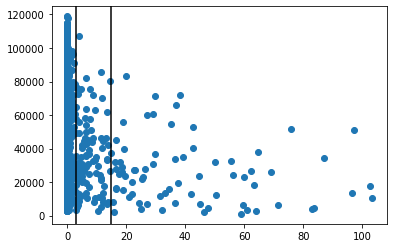

In [27]:
plt.scatter(train_data['precipitation'], train_data['rental'])
plt.axvline(x=3, color='k')
plt.axvline(x=15, color='k')

- 비가 많이오면(기상청 기준 15mm 이상) 확실히 대여량이 크게 감소함 : 0.56배
- 보통비(3~15mm) 또한 0.63배로 대여량이 감소 
- 그럼에도 기준을 15 mm 이상으로 잡은 이유
    - 소나기의 경우 지속시간이 짧기에 강수량이 낮아 보통비(3~15) 범위에 포함된다고 판단
    - 지속시간이 짧으면 수요량에도 크게 영향이 없다고 추측할 수 있음
    - 따라서 확실한 15 이상 날을 대상으로 후처리

In [28]:
print(train_data.loc[train_data['precipitation'] > 15, 'rental'].mean() / train_data.loc[train_data['precipitation'] <= 15, 'rental'].mean())
print(train_data.loc[train_data['precipitation'] > 3, 'rental'].mean() / train_data.loc[train_data['precipitation'] <= 3, 'rental'].mean())

0.5127938523958275
0.6033274414659593


- 강수량 15mm 이상의 날에는 연도별 상승분을 곱하지 않음

In [29]:
test_data['rental_pred'] = np.round(ensemble_pred) # 에버리징 값을 테스트 데이터셋과 병합
test_data.loc[test_data['precipitation'] > 15, 'rental_pred'] = test_data.loc[test_data['precipitation']> 15, 'rental_pred'] / 1.3

# 제출 파일 생성

In [30]:
sample_submission = pd.read_csv('./dataset/sample_submission.csv')
sample_submission["rental"] = test_data['rental_pred']
sample_submission

,date,rental
0,2021-01-01,24425.0
1,2021-01-02,17554.0
2,2021-01-03,12850.0
3,2021-01-04,26879.0
4,2021-01-05,22378.0
...,...,...
360,2021-12-27,36758.0
361,2021-12-28,40185.0
362,2021-12-29,50382.0
363,2021-12-30,46400.0


In [31]:
sample_submission.to_csv('[이전끝]final_submission.csv', index=False)